<a href="https://colab.research.google.com/github/zyythn/Assignment-MV/blob/main/q4_stepdecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
!pip install torch-lr-scheduler

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(), # convert to 4d-tensor
     transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])]
)

train_dir = '/content/drive/MyDrive/MV/tom and jerry/train'
test_dir = '/content/drive/MyDrive/MV/tom and jerry/test'

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=transform)

In [ ]:
class_names = train_data.classes
class_names

['jerry', 'no tom jerry', 'tom', 'tom jerry']

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,batch_size=4, shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=4, shuffle=False)

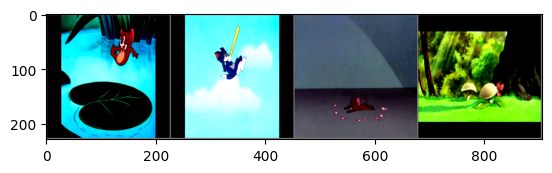

jerry   tom jerry jerry


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Visualize our dataset
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [ ]:
train_imgBatch, train_labelBatch = next(iter(train_dataloader))

train_imgBatch.shape

torch.Size([4, 3, 224, 224])

In [ ]:
# Define our model
class CNNmodel(nn.Module):
  def __init__(self):
    super(CNNmodel,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) #220x220x6
    self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) #110x110x6
    self.conv2 = nn.Conv2d(6,16,5) #53x53x16
    self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2) #26x26x16
    self.conv3 = nn.Conv2d(16, 20, 3) #12x12x20
    self.fc1 = nn.Linear(52020,20*12*12)
    self.fc2 = nn.Linear(20*12*12,4)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.batchnorm1 = nn.BatchNorm2d(6)
    self.batchnorm2 = nn.BatchNorm2d(16)
    self.dropout = nn.Dropout(0.6) #drop 60% of neurons during training

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.batchnorm1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.relu(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.relu(x)
    out = self.fc2(x)

    return out

In [ ]:
model = CNNmodel()

In [ ]:
model.to('cuda')

CNNmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=52020, out_features=2880, bias=True)
  (fc2): Linear(in_features=2880, out_features=4, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

In [ ]:
# cross-entropy loss
loss_fn = nn.CrossEntropyLoss()
loss_fn.to('cuda')
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
# Learning rate scheduler - Step Decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  epoch_start = time.time()
  print("Epoch: {}/{}".format(epoch+1, num_epochs))

  model.train()

  train_loss = 0.0
  train_acc = 0.0

  valid_loss = 0.0
  valid_acc = 0.0

  for inputs, labels in train_dataloader:

    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    # Clean existing gradients
    optimizer.zero_grad()

    # Forward pass - compute outputs on input data using the model
    outputs = model(inputs)

    # Compute loss
    loss = loss_fn(outputs, labels)

    # Backpropagate the gradients
    loss.backward()

    # Update the parameters
    optimizer.step()

    # Compute the total loss for the batch and add it to train_loss
    train_loss += loss.item() * inputs.size(0)

    # Compute the accuracy
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))

    # Convert correct_counts to float and then compute the mean
    acc = torch.mean(correct_counts.type(torch.FloatTensor))

    # Compute total accuracy in the whole batch and add to train_acc
    train_acc += acc.item() * inputs.size(0)

  # Validation - No gradient tracking needed
  with torch.no_grad():

    model.eval()

    # Validation loop
    for inputs, labels in test_dataloader:
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')

      # Forward pass - compute outputs on input data using the model
      outputs = model(inputs)

      # Compute loss
      loss = loss_fn(outputs, labels)

      # Compute the total loss for the batch and add it to valid_loss
      valid_loss += loss.item() * inputs.size(0)

      # Calculate validation accuracy
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      # Convert correct_counts to float and then compute the mean
      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      # Compute total accuracy in the whole batch and add to valid_acc
      valid_acc += acc.item() * inputs.size(0)


  # Find average training loss and training accuracy
  avg_train_loss = train_loss / len(train_dataloader.dataset)
  avg_train_acc = train_acc / len(train_dataloader.dataset)

  # Find average validation loss and training accuracy
  avg_test_loss = valid_loss / len(test_dataloader.dataset)
  avg_test_acc = valid_acc / len(test_dataloader.dataset)

  # Update the learning rate
  scheduler.step()

  # Print the learning rate value
  lr = scheduler.get_last_lr()

  print("Epoch : {:03d}, Training: Accuracy: {:.4f}%, \n\t\tValidation : Accuracy: {:.4f}%".format(epoch, avg_train_acc * 100, avg_test_acc * 100))

Epoch: 1/10
Epoch : 000, Training: Accuracy: 88.2353%, 
		Validation : Accuracy: 42.4025%
Epoch: 2/10
Epoch : 001, Training: Accuracy: 93.5536%, 
		Validation : Accuracy: 41.0103%
Epoch: 3/10
Epoch : 002, Training: Accuracy: 95.6890%, 
		Validation : Accuracy: 40.8910%
Epoch: 4/10
Epoch : 003, Training: Accuracy: 96.8977%, 
		Validation : Accuracy: 40.2148%
Epoch: 5/10
Epoch : 004, Training: Accuracy: 96.8977%, 
		Validation : Accuracy: 40.6523%
Epoch: 6/10
Epoch : 005, Training: Accuracy: 97.9855%, 
		Validation : Accuracy: 41.2092%
Epoch: 7/10
Epoch : 006, Training: Accuracy: 98.4287%, 
		Validation : Accuracy: 41.6070%
Epoch: 8/10
Epoch : 007, Training: Accuracy: 98.5093%, 
		Validation : Accuracy: 42.2434%
Epoch: 9/10
Epoch : 008, Training: Accuracy: 98.8316%, 
		Validation : Accuracy: 41.3683%
Epoch: 10/10
Epoch : 009, Training: Accuracy: 99.2748%, 
		Validation : Accuracy: 43.5959%
